<a href="https://colab.research.google.com/github/kiran74-ds/zero_shot_learning/blob/main/Zero_Shot_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Zero shot learning aims to solve a task to identify classes that are not seen by the model during training.

#### For example, let’s say you have seen a horse but never seen a zebra. If I tell you that a zebra looks like a horse but it has black and white stripes, you will probably immediately recognize a zebra when you see it.

#### This is what zero-shot learning aims to tackle.

#### The high-level strategy we adopt while coding up Zero-shot learning is:
1. Import dataset- which constitutes training images and their corresponding class labels
2. Fetch the word vectors corresponding to each class from pre-trained word vector models.
3. Pass the image through a pre-trained image model like VGG16 and obtain image embedding.
4. We expect the network to predict the word vector corresponding to the object in the image.
5. Once we train the model, predict word vector on new images.
6. The class of word vector that is closest to the predicted word vector is the class of image.

<img src="https://www.learnopencv.com/wp-content/uploads/2020/06/zero-shot-learning-embedding-based-methods.png">


**Train Classes**:
arm, boy, bread, chicken, child, computer, ear, house, leg, sandwich, television, truck, vehicle, watch, woman

**Zero-Shot Classes**:
car, food, hand, man, neck


In [1]:
!git clone https://github.com/kiran74-ds/zsl.git

Cloning into 'zsl'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 123 (delta 57), reused 37 (delta 7), pack-reused 0
Receiving objects: 100% (123/123), 42.19 MiB | 16.32 MiB/s, done.
Resolving deltas: 100% (57/57), done.


**Import Libraries**

In [2]:
%cd zsl
import gzip
import _pickle as cPickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, normalize 
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/content/zsl


#### Image Embeddings

Then, image features are extracted from these cropped images using a pre-trained model, VGG16 in our case . Feature extractor class can be seen below.

In [14]:
DATAPATH = "data/zeroshot_data.pkl"

#### Class Embeddings

Class embedding is the vector representation of a class (class label)

After we have extracted the image features and formed the datasets, now we should gather the other representations of classes, word embeddings namely. We will use Google Word2Vec representation trained on Google News documents. We will get a Wor2Vec of 300 dimensions for each of the 20 object classes we have specified

In [15]:
WORD2VECPATH = "data/class_vectors.npy" 

In [16]:
with open('data/train_classes.txt', 'r') as infile: 
  train_classes = [str.strip(line) for line in infile]
train_classes

['arm',
 'boy',
 'bread',
 'chicken',
 'child',
 'computer',
 'ear',
 'house',
 'leg',
 'sandwich',
 'television',
 'truck',
 'vehicle',
 'watch',
 'woman']

In [17]:
with open('data/zsl_classes.txt', 'r') as infile: 
  zsl_classes = [str.strip(line) for line in infile]
zsl_classes

['car', 'food', 'hand', 'man', 'neck']

**Load the Data** 

In [18]:
def load_data():
  # Load the feature vector data
  with gzip.GzipFile(DATAPATH, 'rb') as infile: 
    data = cPickle.load(infile)

  # Define the training classes and the classes that belong to zero-shot. 
  # Note that, we will only show the classes belonging to training classes and hide the zero-shot model classes until the inference time

  training_data = [instance for instance in data if instance[0] in train_classes]
  zero_shot_data = [instance for instance in data if instance[0] not in train_classes]
  np.random.shuffle(training_data)

  # Fetch 300 training images per class for training and the remaining training class images into validation
  train_size = 300 # per class
  train_data, valid_data = [], [] 
  for class_label in train_classes:
    ctr = 0
    for instance in training_data:
      if instance[0] == class_label:
        if ctr < train_size:
            train_data.append(instance)
            ctr+=1 
        else:
            valid_data.append(instance)

  # Shuffle the training and validation data and fetch the vectors corresponding to the classes into a dictionary 
  np.random.shuffle(train_data)
  np.random.shuffle(valid_data)
  vectors = {i:j for i,j in np.load(WORD2VECPATH, allow_pickle=True)}

  # Fetch the training, validation, and zero-shot classes
  train_clss = [clss for clss,feat in train_data] 
  valid_clss = [clss for clss,feat in valid_data] 
  zero_shot_clss = [clss for clss,feat in zero_shot_data]

  # Fetch the image and word embedding features for training and validation data
  train_data = [(feat, vectors[clss]) for clss,feat in train_data] 
  valid_data = [(feat, vectors[clss]) for clss,feat in valid_data]

  # Define the input and output arrays of training data, validation data, and zero- shot data
  x_train, y_train = zip(*train_data)
  x_train, y_train = np.squeeze(np.asarray(x_train)), np.squeeze(np.asarray(y_train))
  x_train = normalize(x_train, norm='l2')

  x_valid, y_valid = zip(*valid_data)
  x_valid, y_valid = np.squeeze(np.asarray(x_valid)), np.squeeze(np.asarray(y_valid))
  x_valid = normalize(x_valid, norm='l2')

  y_zsl, x_zsl = zip(*zero_shot_data)
  x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)), np.squeeze(np.asarray(y_zsl))
  x_zsl = normalize(x_zsl, norm='l2')

  # Define the training and validation datasets and dataloaders
  trn_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_train, y_train]])
  val_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_valid, y_valid]])

  trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True) 
  val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

  return trn_dl, val_dl, x_zsl, zero_shot_clss, valid_clss, x_valid

**Model Building and Training**

Build a model that takes the 4096-dimensional feature as input and predicts the 300-dimensional vector as output


In [19]:
def build_model(): 
  return nn.Sequential(
      nn.Linear(4096, 1024), 
      nn.ReLU(inplace=True), 
      nn.BatchNorm1d(1024), 
      nn.Dropout(0.8), 
      nn.Linear(1024, 512), 
      nn.ReLU(inplace=True), 
      nn.BatchNorm1d(512), 
      nn.Dropout(0.8), 
      nn.Linear(512, 256), 
      nn.ReLU(inplace=True), 
      nn.BatchNorm1d(256), 
      nn.Dropout(0.8), 
      nn.Linear(256, 300)
)

Functions to train and validate on a batch of data

In [20]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, labels = data
  _preds = model(ims)
  optimizer.zero_grad()
  loss = criterion(_preds, labels)
  loss.backward() 
  optimizer.step() 
  return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()
  ims, labels = data
  _preds = model(ims)
  loss = criterion(_preds, labels) 
  
  return loss.item()

Train the model over increasing epochs

In [21]:
trn_dl, val_dl, x_zsl, zero_shot_clss, valid_clss, x_valid = load_data()
model = build_model().to(device)

print(model)

Sequential(
  (0): Linear(in_features=4096, out_features=1024, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.8, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.8, inplace=False)
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.8, inplace=False)
  (12): Linear(in_features=256, out_features=300, bias=True)
)


In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

n_epochs = 65
train_losses, valid_losses = [], []
for ex in range(n_epochs):
  N = len(trn_dl)
  running_loss = 0 
  for bx, data in enumerate(trn_dl):
    batch_loss = train_batch(model, data, optimizer, criterion) 
    running_loss += batch_loss *32 
  train_epoch_loss = running_loss / N
  train_losses.append(train_epoch_loss)

  N = len(val_dl)
  running_loss = 0 
  for bx, data in enumerate(val_dl):
    batch_loss = validate_batch(model, data, criterion)
    running_loss += batch_loss *32 
  valid_epoch_loss = running_loss / N
  valid_losses.append(valid_epoch_loss)
  print("Epoch {} , training loss {}, valid loss {}".format(ex+1, train_epoch_loss, valid_epoch_loss))

  if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4) 
  if ex == 40: optimizer = optim.Adam(model.parameters(), lr=1e-5) 


Epoch 1 , training loss 19.311561143144647, valid loss 0.659882977921912
Epoch 2 , training loss 1.4065709143665666, valid loss 0.5578956363048959
Epoch 3 , training loss 0.6302999503223609, valid loss 0.5477650343103612
Epoch 4 , training loss 0.6177237215617024, valid loss 0.5314818081703592
Epoch 5 , training loss 0.6219183536286049, valid loss 0.5236650318541425
Epoch 6 , training loss 0.624090904462422, valid loss 0.5101646108830229
Epoch 7 , training loss 0.6216274816939171, valid loss 0.5001975716428554
Epoch 8 , training loss 0.6266054320842662, valid loss 0.4896337218741153
Epoch 9 , training loss 0.6282388580606338, valid loss 0.47958982624906177
Epoch 10 , training loss 0.6251335177861207, valid loss 0.4750259861033014
Epoch 11 , training loss 0.6226986739652377, valid loss 0.4747326608667982
Epoch 12 , training loss 0.5585177912779734, valid loss 0.44596682710850494
Epoch 13 , training loss 0.512433076158483, valid loss 0.43887081869105077
Epoch 14 , training loss 0.5002666

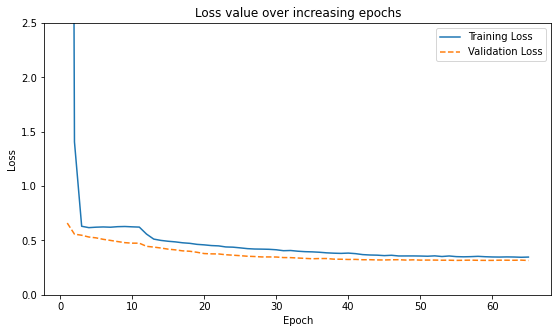

In [23]:
import matplotlib.pyplot as plt
epochs = np.arange(n_epochs)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs') 
plt.plot(epochs, train_losses, label='Training Loss') 
plt.plot(epochs, valid_losses, label='Validation Loss', linestyle='dashed') 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 2.5)
plt.legend();

**Model Evaluation**

Predict on images that contain the zero-shot classes (classes which the model has not seen) and also fetch the actual features and classnames corresponding to the zero-shot classes

In [24]:
pred_zsl = model(torch.Tensor(x_zsl).to(device)).cpu().detach().numpy()

class_vectors = sorted(np.load(WORD2VECPATH, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames = list(classnames)

vectors = np.array(vectors)

Calculate the distance between each predicted vector and the vector corresponding to the available classes and measure the number of zero-shot classes present in the top 5 predictions

In [30]:
dists = (pred_zsl[None] - vectors[:,None]) 
dists = (dists**2).sum(-1).T

best_classes_5 = []
best_classes_3 = []
best_classes_2 = []
best_classes_1 = []
for item in dists:
  best_classes_5.append([classnames[j] for j in np.argsort(item)[:5]])
  best_classes_3.append([classnames[j] for j in np.argsort(item)[:3]])
  best_classes_2.append([classnames[j] for j in np.argsort(item)[:2]])
  best_classes_1.append([classnames[j] for j in np.argsort(item)[:1]])

top5 = np.mean([i in J for i,J in zip(zero_shot_clss, best_classes_5)])
top3 = np.mean([i in J for i,J in zip(zero_shot_clss, best_classes_3)])
top2 = np.mean([i in J for i,J in zip(zero_shot_clss, best_classes_2)])
top1 = np.mean([i in J for i,J in zip(zero_shot_clss, best_classes_1)])



print("Top 5 Accuracy : ",top5)
print("Top 3 Accuracy : ",top3)
print("Top 2 Accuracy : ",top2)
print("Top 1 Accuracy : ",top1)

Top 5 Accuracy :  0.7743871935967984
Top 3 Accuracy :  0.38969484742371185
Top 2 Accuracy :  0.15107553776888444
Top 1 Accuracy :  0.05102551275637819


We can predict correctly for ~78% of the images that contain an object whose class is not present during training, in the top 5 predictions of the model.
Note that the percentage of correctly classified images will be 6%, 14%, and 40% for top 1,2,3 predictions, respectively